In [193]:
import torch
import os
import re
import math

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader

In [194]:
class aerialBuildingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and text. Of the form ./data/genTrain etc...
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.maps = os.listdir(root_dir) #These are all the maps in the root. austin10 chicago55 etc...
        self.root_dir = root_dir 
        self.transform = transform 

        #Retrieve all the image locations with their coordinates
        self.imageList = [] #List of images e.g ./data/genTrain/austin10/860.png
        self.cornerList = [] #Get all the image paths in our dataset
        for map in self.maps:
            images = [x for x in os.listdir(os.path.join(root_dir,map)) if re.search("png",x)]
            coordinates = [x for x in os.listdir(os.path.join(root_dir,map)) if re.search("txt",x)]
            for image in images:
                number = image.split('.png')[0]
                corner = [x for x in coordinates if re.search('^'+number+'.txt',x)][0]
                if len(corner) == 0:
                    break
                self.cornerList.append(os.path.join(root_dir, map,corner))
                self.imageList.append(os.path.join(root_dir, map,image))
        if (len(self.imageList) != len(self.cornerList)):
            raise ValueError('Oops, mismatch in images and coordinate files')
        
    def __len__(self):
        return len(self.imageList)

    def __getitem__(self, idx):
        img_file = os.path.join(self.imageList[idx])
        image = io.imread(img_file)
        image = image[:,:,0:3]
        corner_file = self.cornerList[idx]
        with open(corner_file) as f:
            content = f.readlines()
            content = np.array([x.strip().split(' ') for x in content])
        sample = {'image': image, 'corners': content}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [195]:
#helper function to show building and its corners.
def show_landmarks(image, corners):
    plt.figure(figsize=(4,4))
    """Show image with landmarks"""
    plt.imshow(image)
    print(corners)
    plt.scatter(corners[:, 0], corners[:, 1], s=10, marker='.', c='r')
    plt.show()

In [196]:
#Load the dataset
building_dataset = aerialBuildingDataset(root_dir='./data/genTrain')

In [ ]:
sample = building_dataset[1042]
print("image shape", sample['image'].shape, "corner shape", sample['corners'].shape)
show_landmarks(**sample)

For each input image, VGG-16 is used without tail layers as the backbone to extract a set of "skip features" 1/8 the size of input images. Then this goes through conv layers to obtain a heat-map mask of boundaries. This is then convolved to output a mask of candidate keypoints (V). Both B and V have size 1/8 the original image

In [163]:
class SamePad2d(nn.Module):
    """Mimics tensorflow's 'SAME' padding.
    """

    def __init__(self, kernel_size, stride):
        super(SamePad2d, self).__init__()
        self.kernel_size = torch.nn.modules.utils._pair(kernel_size)
        self.stride = torch.nn.modules.utils._pair(stride)

    def forward(self, input):
#         print(input.shape)
        in_width = input.size()[2]
        in_height = input.size()[3]
#         print("in_width", in_width, "and in_height", in_height)
        out_width = math.ceil(float(in_width) / float(self.stride[0]))
        out_height = math.ceil(float(in_height) / float(self.stride[1]))
        pad_along_width = ((out_width - 1) * self.stride[0] +
                           self.kernel_size[0] - in_width)
        pad_along_height = ((out_height - 1) * self.stride[1] +
                            self.kernel_size[1] - in_height)
        pad_left = math.floor(pad_along_width / 2)
        pad_top = math.floor(pad_along_height / 2)
        pad_right = pad_along_width - pad_left
        pad_bottom = pad_along_height - pad_top
        return F.pad(input, (pad_left, pad_right, pad_top, pad_bottom), 'constant', 0)

    def __repr__(self):
        return self.__class__.__name__

In [217]:
#Network consisting of the skipfeature convolutions for generating 1/8 mask of candidate keypoints.

class Mask(nn.Module):
    def __init__(self, depth, pool_size, image_shape):
        super(Mask, self).__init__()
        self.depth = depth
        self.pool_size = pool_size
        self.image_shape = image_shape
        self.num_classes = 1
        self.padding = SamePad2d(kernel_size=3, stride=1)
        self.conv1 = nn.Conv2d(self.depth, 256, kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm2d(256, eps=0.001)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(256, eps=0.001)
        self.conv3 = nn.Conv2d(256, 256, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(256, eps=0.001)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1)
        self.bn4 = nn.BatchNorm2d(256, eps=0.001)
#         self.deconv = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(256, self.num_classes, kernel_size=1, stride=1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
#  We input individual buildings
#         x = pyramid_roi_align([rois] + x, self.pool_size, self.image_shape)
        print("Input to mask x is ", x.shape)
        x = self.conv1(self.padding(x))
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(self.padding(x))
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(self.padding(x))
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv4(self.padding(x))
        x = self.bn4(x)
        x = self.relu(x)
#         x = self.deconv(x)
#         x = self.relu(x)
        x = self.conv5(x)
        x = self.sigmoid(x)
        print("Shape of x after foward", x.shape)

        return x

In [218]:
# #VGG net simplified.

# class VGG1(nn.Module):
#     def __init__(self, depth, pool_size, image_shape)

In [219]:
class GeoNet(nn.Module):
    def __init__(self, model_dir):
        """
        config: A Sub-class of the Config class
        model_dir: Directory to save training logs and trained weights
        """
        super(GeoNet, self).__init__()
        self.MASK_POOL_SIZE = 288
        self.IMAGE_SHAPE = 288
        self.model_dir = model_dir
        self.build()
        self.initialize_weights()
    
    def build(self):
        """Build GeoNet architecture.
        """
#         Todo: Replace simple convolution of input to skip feature input. Using mask of 3 for 3 RGB
#         self.backbone = Backbone(3)
        self.mask = Mask(3, self.MASK_POOL_SIZE, self.IMAGE_SHAPE)


    def initialize_weights(self):
        """Initialize model weights.
        """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
                
    def predict(self, input, mode):
        molded_images = input

        if mode == 'inference':
            self.eval()
        elif mode == 'training':
            self.train()
            # Set batchnorm always in eval mode during training
            def set_bn_eval(m):
                classname = m.__class__.__name__
                if classname.find('BatchNorm') != -1:
                    m.eval()
            self.apply(set_bn_eval)
            
        #FPN and BBox extraction here.
        mrcnn_feature_maps = molded_images

        if mode == 'inference':
            # Network Heads
            # Create masks for detections
            mrcnn_mask = self.mask(mrcnn_feature_maps)

            # Add back batch dimension
#             mrcnn_mask = mrcnn_mask.unsqueeze(0)
            return mrcnn_mask

        return results

In [220]:
net = GeoNet('./placeholderDir')
net.eval()

GeoNet(
  (mask): Mask(
    (padding): SamePad2d
    (conv1): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))
    (bn1): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (bn2): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (bn3): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (bn4): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    (sigmoid): Sigmoid()
    (relu): ReLU(inplace)
  )
)

In [221]:
inputBatch = torch.Tensor(building_dataset[1032]['image'])
inputBatch = torch.unsqueeze(inputBatch, 0)
inputBatch = inputBatch.permute(0,3,1,2)
print("Our inputBatch is of shape", inputBatch.shape)
CornerMask = net.predict(inputBatch,"inference")

Our inputBatch is of shape torch.Size([1, 3, 288, 288])
Input to mask x is  torch.Size([1, 3, 288, 288])
torch.Size([1, 3, 288, 288])
in_width 288 and in_height 288
torch.Size([1, 256, 288, 288])
in_width 288 and in_height 288
torch.Size([1, 256, 288, 288])
in_width 288 and in_height 288
torch.Size([1, 256, 288, 288])
in_width 288 and in_height 288
Shape of x after foward torch.Size([1, 1, 288, 288])


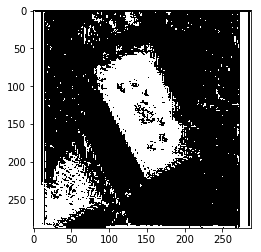

In [236]:
#Take first batch dimension.
show = PointMask[0].detach().numpy()
#Squeeze the class dim.
show = show.squeeze(0)

# Z is your data set
N = 288

# G is a NxNx3 matrix
G = np.zeros((N,N,3))

# Where we set the RGB for each pixel
G[show>0.9] = [1,1,1]
G[show<0.9] = [0,0,0]

plt.imshow(G,interpolation='nearest')
plt.show()